Import Package
=============================

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import warnings

warnings.filterwarnings('ignore')

Data Reading
=============================================

In [43]:
df_customer = pd.read_csv(r'/content/Customer.csv', delimiter=";")
df_product = pd.read_csv(r'/content/Product.csv', delimiter=";")
df_store= pd.read_csv(r'/content/Store.csv', delimiter=";")
df_transaction= pd.read_csv(r'/content/Transaction.csv', delimiter=";")

In [44]:
print("jumlah baris & kolom tabel customer= ",df_customer.shape)
print("jumlah baris & kolom tabel product= ",df_product.shape)
print("jumlah baris & kolom tabel store= ", df_store.shape)
print("jumlah baris & kolom tabel transaction= ",df_transaction.shape)

jumlah baris & kolom tabel customer=  (447, 5)
jumlah baris & kolom tabel product=  (10, 3)
jumlah baris & kolom tabel store=  (14, 6)
jumlah baris & kolom tabel transaction=  (5020, 8)


Data Cleansing
==========================================

cleansing data customer

In [45]:
df_customer.head(5)       #menampilkan 5 baris data pertama dr data customer

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [46]:
#mengubah , menjadi . pada kolom income dan mengubahnya menjadi tipe data float
df_customer['Income']= df_customer['Income'].replace('(,)','.', regex=True).astype(float)

In [47]:
#menghitung data berganda
df_customer.duplicated().sum()

0

In [48]:
#menampilkan baris data yang memiliki CustomerID ganda
df_customer[df_customer.duplicated(subset=['CustomerID'])]

,CustomerID,Age,Gender,Marital Status,Income


In [49]:
#mendeteksi kolom yang memiliki nilai Null
df_customer.isnull().any()

CustomerID        False
Age               False
Gender            False
Marital Status     True
Income            False
dtype: bool

In [50]:
#karena kolom marital_status memiliki nilai null, maka akan ditampilkan
#baris data yang memiliki nilai null pada kolom marital_status
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4.00
415,416,27,1,NaN,3.43
442,443,33,1,NaN,9.28


In [51]:
#menghapus baris data yang memiliki nilai null
df_customer.dropna(subset=['Marital Status'], inplace=True)

cleansing data product

In [82]:
#menampilkan 5 baris data pada df_product
df_product.head(5)

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [81]:
#menampilkan baris data yang memiliki ProductID ganda
df_product[df_product.duplicated(subset=['ProductID'])]

,ProductID,Product Name,Price


In [53]:
#mendeteksi kolom yang memiliki nilai Null
df_product.isnull().any()

ProductID       False
Product Name    False
Price           False
dtype: bool

cleansing data store

In [54]:
#menampilkan 5 baris data pada df_store
df_store.head(5)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [55]:
#mengubah , menjadi . pada kolom latitude dan longitude
#dan mengubahnya menjadi tipe data float
df_store['Latitude']=df_store['Latitude'].replace('(,)','.', regex=True).astype(float)
df_store['Longitude']=df_store['Longitude'].replace('(,)','.', regex=True).astype(float)

In [56]:
#mendeteksi kolom yang memiliki nilai Null
df_store.isnull().any()

StoreID       False
StoreName     False
GroupStore    False
Type          False
Latitude      False
Longitude     False
dtype: bool

In [57]:
#menampilkan baris data yang memiliki StoreID ganda
df_store[df_store.duplicated(subset=['StoreID'])].sum()

StoreID       0.0
StoreName     0.0
GroupStore    0.0
Type          0.0
Latitude      0.0
Longitude     0.0
dtype: float64

cleansing data transaction

In [59]:
#menampilkan 5 baris data pada df_transaction
df_transaction.head(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [60]:
#mengubah datatype kolom date
df_transaction['Date']=pd.to_datetime(df_transaction['Date'])

In [61]:
#menghitung baris data yang terduplikat
df_transaction.duplicated().sum()

0

In [62]:
#menampilkan TransactionID yang muncul lebih dari sekali
value_counts = df_transaction['TransactionID'].value_counts()
value_counts[value_counts > 1]

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR2135     2
TR49903    2
TR99533    2
TR36057    2
TR49304    2
Name: TransactionID, Length: 111, dtype: int64

In [63]:
#menampilkan baris data yang memiliki TransactionID di tanggal yang sama
duplicate_dates = df_transaction.groupby(['TransactionID', 'Date']).size()
duplicate_dates[duplicate_dates > 1]

Series([], dtype: int64)

In [64]:
#mengurutkan data berdasarkan yang telama hingga terbaru
df_transaction = df_transaction.sort_values('Date', ascending=True)
#menghapus data lama yang memiliki TransactionID yang sama dan mempertahankan
#data terbaru
df_transaction.drop_duplicates(subset='TransactionID', keep='last', inplace=True)
#melakukan pengecekan ulang kembali
value_counts = df_transaction['TransactionID'].value_counts()
value_counts[value_counts > 1]

Series([], Name: TransactionID, dtype: int64)

#Menggabungkan Data

In [65]:
#menggabungkan seluruh data
df_merged=pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merged=pd.merge(df_merged, df_product.drop(columns=['Price']), on=['ProductID'])
df_merged=pd.merge(df_merged, df_store, on=['StoreID'])

In [66]:
#menampilkan 5 baris data df_merged (data gabungan)
df_merged.head(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR11644,293,2022-08-30,P3,7500,1,7500,12,54,0,Married,10.40,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR38909,285,2022-04-03,P3,7500,4,30000,12,20,0,Single,0.00,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


#Model ML Regression (Time Series)
Hal ini dilakukan untuk mendapatkan prediksi total quantity untuk stock harian yang dibutuhkan oleh tim Inventory

In [67]:
#membuat data baru untuk regression
df_regretion = df_merged.groupby(['Date']).agg({
    'Qty': 'sum'
}).reset_index()

In [68]:
#menampilkan tabel df_regretion yang telah dibuat
df_regretion

,Date,Qty
0,2022-01-01,47
1,2022-01-02,45
2,2022-01-03,67
3,2022-01-04,98
4,2022-01-05,57
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


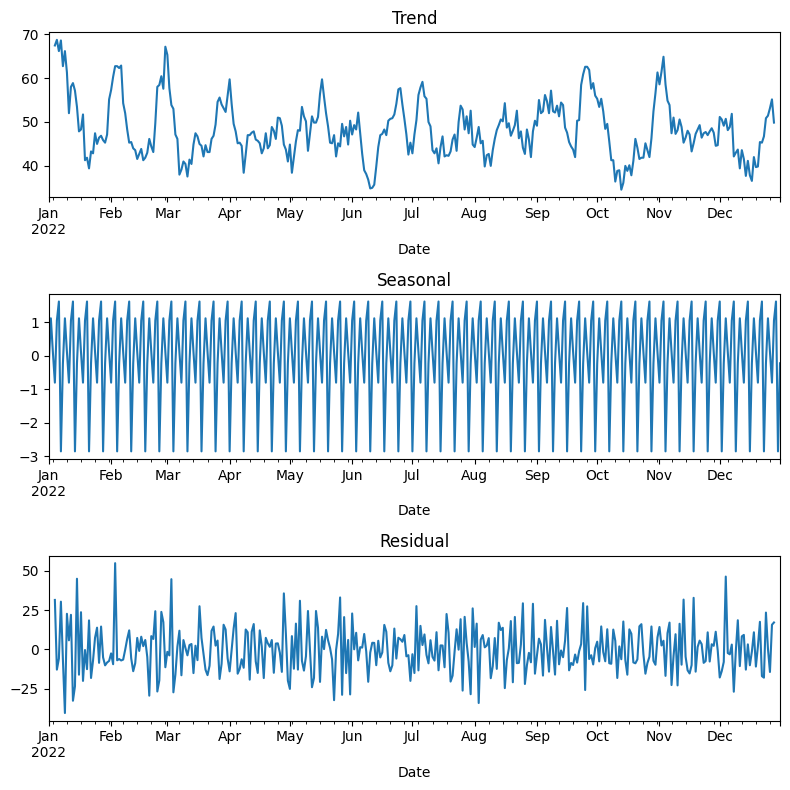

In [69]:
# Melakukan dekomposisi seasonal
decomposed = seasonal_decompose(df_regretion.set_index('Date'))

# Mengatur ukuran figure
plt.figure(figsize=(8,8))
# Menampilkan trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
# Menampilkan seasonal
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
# Menampilkan residu
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
# Mengatur layout agar rapi
plt.tight_layout()

In [70]:
from statsmodels.tsa.stattools import adfuller
# Melakukan uji Augmented Dickey-Fuller (ADF) pada kolom Qty dari data 'df_regretion'
result = adfuller(df_regretion['Qty'])
# Menampilkan ADF Statistic, p-value, dan Critical Values dari hasil uji ADF
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.382389
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [71]:
# Bagi data menjadi train dan test
cut_off = round(df_regretion.shape[0] * 0.8)
df_train = df_regretion[:cut_off]
df_test = df_regretion[cut_off:]

In [89]:
df_train

,Date,Qty
0,2022-01-01,47
1,2022-01-02,45
2,2022-01-03,67
3,2022-01-04,98
4,2022-01-05,57
...,...,...
287,2022-10-15,33
288,2022-10-16,24
289,2022-10-17,53
290,2022-10-18,47


In [90]:
df_test

,Date,Qty
292,2022-10-20,39
293,2022-10-21,35
294,2022-10-22,56
295,2022-10-23,59
296,2022-10-24,39
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


RMSE value: 15.964036267001969
MAE value: 12.766657183601572


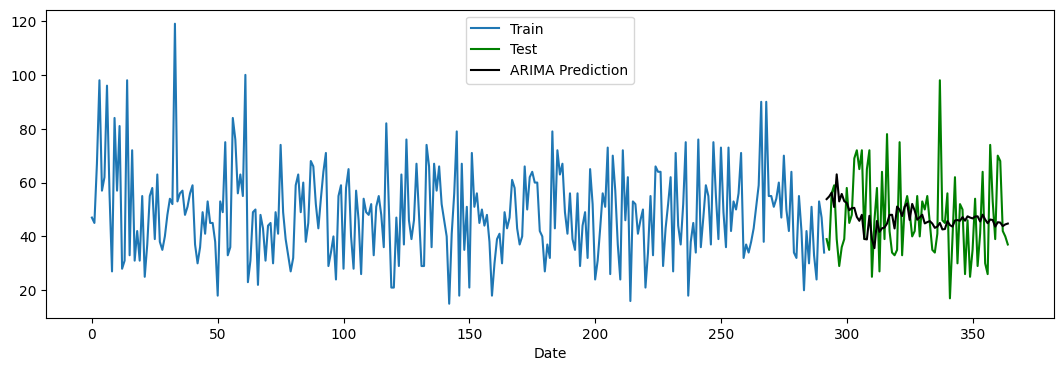

In [91]:
# Gunakan 'Qty' dari df_train sebagai target (y)
y = df_train['Qty']

# Latih model ARIMA
ARIMAmodel = ARIMA(y, order=(40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

# Prediksi
y_pred = ARIMAmodel.get_forecast(steps=len(df_test))
y_pred_out = y_pred.predicted_mean

# Evaluasi prediksi
def eval(y_actual, y_pred):
    print(f'RMSE value: {mean_squared_error(y_actual, y_pred)**0.5}')
    print(f'MAE value: {mean_absolute_error(y_actual, y_pred)}')

eval(df_test['Qty'], y_pred_out)

# Plot hasil
plt.figure(figsize=(13, 4))
plt.plot(df_train.index, df_train['Qty'], label='Train')
plt.plot(df_test.index, df_test['Qty'], color='green', label='Test')
plt.plot(df_test.index, y_pred_out, color='black', label='ARIMA Prediction')
plt.xlabel('Date')  # Tambahkan label untuk sumbu x
plt.legend()
plt.show()

In [99]:
# Prediksi 30 hari ke depan setelah df_test
forecast_period = 30
forecast = ARIMAmodel.forecast(steps=forecast_period)

# Tampilkan tabel hasil prediksi
forecast_df = pd.DataFrame({
    'Qty Prediction': forecast
})
print(forecast_df)

     Qty Prediction
365       57.401066
366       44.312594
367       47.101040
368       52.451876
369       41.760615
370       35.707779
371       46.288058
372       35.235355
373       42.970687
374       52.417359
375       37.807995
376       40.343438
377       44.355327
378       38.867982
379       43.584359
380       45.306479
381       44.403860
382       53.191250
383       40.117323
384       41.204421
385       52.853685
386       37.209324
387       40.080388
388       57.563988
389       46.735598
390       40.568433
391       51.956437
392       41.843592
393       40.803052
394       46.723052


#Model ML Clustering
hal ini dilakukan agar mendapatkan segment customer yang dibutuhkan oleh tim marketing

In [73]:
#meninjau korelasi pada kolom kolom di data gabungan
df_merged.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016848,-0.013039,-0.027297,0.008386,-0.022445,-0.018030,0.004778,0.006296,-0.006894
Price,-0.016848,1.000000,-0.353870,0.440091,-0.031161,0.014174,0.011297,0.001985,-0.026628,0.018088
Qty,-0.013039,-0.353870,1.000000,0.621611,0.011983,-0.026400,-0.010760,-0.032228,-0.008123,0.006392
TotalAmount,-0.027297,0.440091,0.621611,1.000000,-0.012294,-0.015377,-0.009347,-0.027208,-0.031321,0.026888
StoreID,0.008386,-0.031161,0.011983,-0.012294,1.000000,-0.007778,-0.002103,0.003226,0.469529,-0.096025
Age,-0.022445,0.014174,-0.026400,-0.015377,-0.007778,1.000000,-0.026988,0.485602,0.007204,0.020950
Gender,-0.018030,0.011297,-0.010760,-0.009347,-0.002103,-0.026988,1.000000,-0.066849,-0.010182,-0.000047
Income,0.004778,0.001985,-0.032228,-0.027208,0.003226,0.485602,-0.066849,1.000000,0.019291,0.002871
Latitude,0.006296,-0.026628,-0.008123,-0.031321,0.469529,0.007204,-0.010182,0.019291,1.000000,-0.393545
Longitude,-0.006894,0.018088,0.006392,0.026888,-0.096025,0.020950,-0.000047,0.002871,-0.393545,1.000000


In [74]:
# Mengelompokkan data berdasarkan 'CustomerID' dan melakukan agregasi
# untuk mendapatkan informasi statistik terkait setiap pelanggan.
df_cluster=df_merged.groupby(('CustomerID')).agg({
    'TransactionID':'count', #Jumlah transaksi yg dilakukan
    'Qty':'sum', #Total kuantitas
    'Age':'first' #Usia pertama tercatat
}).reset_index()
df_cluster.rename(columns={'TransactionID': 'JumlahTransaksi', 'Qty': 'TotalQty'}, inplace=True)
#menampilkan beberapa baris data untuk df_clustering
df_cluster.head()

,CustomerID,JumlahTransaksi,TotalQty,Age
0,1,17,60,55
1,2,12,56,60
2,3,15,56,32
3,4,10,46,31
4,5,7,27,58


In [75]:
data_cluster=df_cluster.drop(columns=['CustomerID']) #menghapus kolom CustomerID
data_cluster_normalize=preprocessing.normalize(data_cluster) #mernomalisasi data
print(data_cluster_normalize)

[[0.20444864 0.72158345 0.66145149]
 [0.14467285 0.67513995 0.72336423]
 [0.22651995 0.84567449 0.48324256]
 ...
 [0.20716308 0.75553595 0.62148925]
 [0.15351993 0.58616699 0.79551234]
 [0.18031357 0.55596683 0.81141105]]


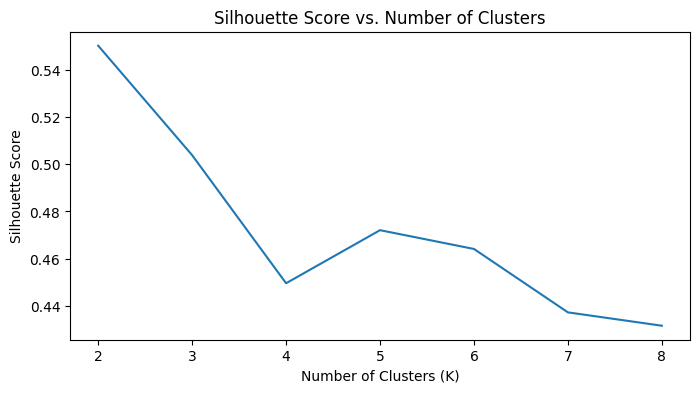

In [76]:
#membuat grafik elbow method
K = range(2, 9)

fits = []
score = []

for k in K:
    model = KMeans(n_clusters=k, random_state=0, n_init='auto')
    model.fit(data_cluster_normalize)
    fits.append(model)
    labels = model.predict(data_cluster_normalize)
    score.append(silhouette_score(data_cluster_normalize, labels))

# Menampilkan grafik Elbow Method
plt.figure(figsize=(8,4))
sns.lineplot(x=K, y=score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xticks(K)  # Tampilkan semua nilai K pada sumbu x
plt.show()


In [77]:
fits[2]

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [78]:
df_cluster['cluster_label']=fits[2].labels_ #masukkan cluster label ke data awal
df_cluster #menampilkan data yang baru

,CustomerID,JumlahTransaksi,TotalQty,Age,cluster_label
0,1,17,60,55,3
1,2,12,56,60,0
2,3,15,56,32,2
3,4,10,46,31,2
4,5,7,27,58,1
...,...,...,...,...,...
439,442,13,37,42,0
440,444,18,62,53,3
441,445,17,62,51,3
442,446,11,42,57,0


In [79]:
# Mengelompokkan data berdasarkan label kluster dan menghitung statistik untuk setiap variabel
# Menghitung jumlah CustomerID, rata-rata JumlahTransaksi, rata-rata TotalQty, dan rata-rata Age untuk setiap kluster
cluster_summary = df_cluster.groupby(['cluster_label']).agg({
    'CustomerID': 'count',  # Menghitung jumlah CustomerID di setiap kluster
    'JumlahTransaksi': 'mean',  # Menghitung rata-rata JumlahTransaksi di setiap kluster
    'TotalQty': 'mean',  # Menghitung rata-rata TotalQty di setiap kluster
    'Age': 'mean'  # Menghitung rata-rata Age di setiap kluster
})

,CustomerID,JumlahTransaksi,TotalQty,Age
cluster_label,,,,
0,122,10.098361,35.622951,46.393443
1,76,7.789474,25.842105,50.486842
2,103,13.135922,50.737864,26.951456
3,143,11.797203,43.006993,37.874126


Cluster 0:
Dalam cluster ini rata-rata transaksi yang dilakukan sekitar 10.1 transaksi. Dan rata-rata total barang yang dibeli oleh customer dalam cluster ini adalah sekitar 35,6. Usia rata-rata customer dalam cluster ini adalah sekitar 46,4 tahun. Cluster ini mungkin mewakili customer dengan tingkat aktivitas belanja menengah hingga tinggi, dengan usia di sekitar pertengahan hingga akhir.

Cluster 1:

Rata-rata transaksi yang dilakukan oleh customer dalam cluster ini adalah sekitar 7.8 transaksi. Dan rata-rata total barang yang dibeli oleh customer dalam cluster ini adalah sekitar 25.8. Rata-rata usia customer dalam cluster ini adalah sekitar 50.5 tahun. Cluster ini mungkin mewakili customer dengan tingkat aktivitas belanja yang lebih rendah dibandingkan dengan cluster lain, dengan usia cenderung lebih tua.

Cluster 2:

Rata-rata transaksi yang dilakukan oleh customer dalam cluster ini adalah sekitar 13.1 transaksi. Rata-rata total barang yang dibeli oleh customer dalam cluster ini adalah sekitar 50.7. Rata-rata usia customer dalam cluster ini adalah sekitar 27.0 tahun. Cluster ini mungkin mewakili customer dengan tingkat aktivitas belanja yang tinggi, dengan usia relatif muda.

Cluster 3:

Rata-rata transaksi yang dilakukan oleh customer dalam cluster ini adalah sekitar 11.8 transaksi. Rata-rata total barang yang dibeli oleh customer dalam cluster ini adalah sekitar 43.0. Rata-rata usia customer dalam cluster ini adalah sekitar 37.9 tahun. Cluster ini mungkin mewakili customer dengan tingkat aktivitas belanja yang cukup tinggi, dengan usia di tengah-tengah.



#Rekomendasi bisnis:
*   Cluster 2 (tingkat aktivitas belanja tinggi, usia muda) dapat menjadi fokus kampanye pemasaran untuk produk-produk baru atau promosi.
*   Cluster 1 (tingkat aktivitas belanja rendah, usia lebih tua) dapat diincar dengan program diskon khusus atau penawaran yang menarik untuk mendorong pembelian lebih lanjut.

Analisis lebih lanjut diperlukan untuk memahami karakteristik dan preferensi pelanggan di setiap cluster guna menyusun strategi pemasaran yang lebih tepat.





